In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

try Monotone interpolants https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html

In [4]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

In [5]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [119]:
# BAAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/R CRB_20231107_054548.csv')
# BAAVSO

AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')
AAVSO

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_69985/3820215782.py:4: DtypeWarning: Columns (1,7,8,9,12,14,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')


,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376818e+06,<7.8,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327815,2.460252e+06,6.5,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
327816,2.460254e+06,6.4,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
327817,2.460254e+06,6.3,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
327818,2.460254e+06,6.1,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [120]:
vband = AAVSO[AAVSO['Band']=='Vis.'].reset_index(drop=True)
vband

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376818e+06,<7.8,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306466,2.460252e+06,6.5,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
306467,2.460254e+06,6.4,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
306468,2.460254e+06,6.3,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
306469,2.460254e+06,6.1,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [121]:
AAVSO_mask = []
for i in range(0,len(vband)):
    
    if str(vband['Magnitude'].iloc[i])[0] == '<' or str(vband['Magnitude'].iloc[i])[0] == '>':
#         print()
        print(i,vband['Magnitude'].iloc[i],vband['Observer Code'].iloc[i])
        AAVSO_mask.append(False)
    else:
#         print(i,vband['Magnitude'].iloc[i])
        AAVSO_mask.append(True)
AAVSO_mask = np.asarray(AAVSO_mask)

# vband['Magnitude'][str(np.asarray(vband['Magnitude']))[0]=='<']

3 <7.8 PIGE
24 <7.8 PIGE
25 <7.8 PIGE
26 <7.8 PIGE
27 <7.8 PIGE
28 <7.8 PIGE
29 <7.8 PIGE
30 <7.8 PIGE
31 <7.8 PIGE
103 <8.0 AFW
104 <8.0 AFW
105 <8.0 AFW
106 <8.0 AFW
107 <8.0 AFW
108 <8.0 AFW
156 <6.2 AFW
181 <10.0 AFW
182 <10.0 AFW
183 <10.0 AFW
184 <10.0 AFW
298 <9.7 AFW
536 <9.3 AFW
577 <9.6 AFW
639 <9.8 AFW
1649 <11.0 MWK
1665 <8.4 RWX
1759 <6.6 PUL
1760 <6.6 PUL
2152 <5.6 MWK
2417 <13.8 VA
2436 <11.8 C
2443 <11.5 C
2482 <11.4 CEL
2661 <10.7 CEL
2787 <10.7 EA
2788 <9.8 SHM
2789 <9.5 O
2790 <13.0 CEL
2793 <10.7 JB
2800 <10.3 O
2801 <10.3 SHM
2805 <10.7 EA
2826 <10.3 SHM
2832 <10.3 JB
4864 <6.1 E
5503 <8.9 VGZ
5506 <10.6 O
5507 <9.2 VGZ
5511 <9.5 LY
5512 <9.0 VGZ
5513 <9.5 LY
5514 <11.4 MAC
5520 <12.2 L
5523 <11.8 PI
5524 <12.2 PIS
5525 <12.0 WHC
5527 <11.4 BUR
5532 <10.7 SHM
5533 <10.0 VGZ
5538 <12.2 BUR
5539 <10.7 CJJ
5543 <12.2 BUR
5546 <11.4 PI
5547 <10.7 SHM
5548 <10.7 V
5549 <10.7 SHM
5551 <13.1 BUR
5552 <12.6 CJJ
5554 <12.2 L
5556 <12.2 BUR
5557 <12.6 CJJ
5559 <9.0 VGZ
5560 

49692 <7.0 LJ
49698 <10.6 DVM
49700 <10.6 HW
49701 <10.6 LKJ
49704 <10.5 RB
49708 <10.5 RB
49715 <10.5 RB
49722 <9.5 SLT
49731 <10.6 SLT
49760 <8.3 ELD
49827 <8.6 PD
49836 <8.6 PD
49852 <8.9 CC
49878 <8.9 CC
49881 <7.0 LJ
49944 <7.0 LJ
50062 <7.0 LJ
50067 <7.0 LJ
50165 <8.3 ELD
50178 <8.2 P
50184 <7.0 LJ
54281 <6.4 WY
54360 <10.29 SGEB
58633 <7.0 HHG
58804 <6.7 BSW
63929 <7.18 SGEB
63944 <10.29 LRJ
63947 <9.83 RFQ
63950 <10.29 LRJ
63955 <10.29 LRJ
63968 <10.29 LRJ
63985 <6.5 OD
63987 <7.93 CTB
63990 <9.49 CTB
63997 <9.2 LRJ
64010 <6.5 OD
64017 <9.49 CTB
64023 <9.49 LRJ
64041 <10.2 RB
64068 <9.36 LRJ
64073 <7.7 FJA
64080 <10.29 LRJ
64086 <7.2 OD
64087 <10.29 LRJ
64099 <10.29 LRJ
64102 <6.5 OD
64106 <7.4 ESG
64119 <11.1 CTB
64129 <11.36 SHEJ
64134 <10.66 CTB
64137 <11.36 CTB
64147 <11.8 SS
64150 <10.66 LRJ
64155 <11.1 DHG
64156 <11.36 SHEJ
64162 <10.6 SS
64172 <11.79 SHEJ
64178 <11.36 FDJ
64185 <10.29 LRJ
64201 <7.5 KS
64204 <12.2 CTB
64206 <7.5 KS
64208 <10.2 RB
64213 <7.5 KS
64218 <10.

86530 <6.28 LRJ
86587 <7.63 HPM
86588 <8.0 MIW
86623 <8.6 HRB
86625 <9.36 TLA
86637 <8.88 HRB
86638 <10.66 TLA
86639 <8.28 HPM
86647 <9.36 HRB
86648 <9.82 TLA
86652 <11.1 SSL
86663 <8.6 HRB
86665 <8.6 HPM
86667 <10.66 TLA
86675 <8.0 MIW
86684 <9.36 TLA
86690 <12.2 LRJ
86699 <9.49 HRB
86700 <10.66 TLA
86737 <9.36 HPM
86746 <9.36 HPM
86778 <11.36 LRJ
86791 <12.2 FJH
86796 <11.36 LRJ
86801 <9.49 HRB
86805 <10.66 TLA
86815 <12.63 LRJ
86835 <9.36 TLA
86838 <11.36 HRB
86840 <10.6 MIW
86853 <10.66 TLA
86854 <11.36 SMJC
86866 <12.2 LRJ
86873 <10.66 HOW
86878 <7.18 HPM
86887 <10.66 SMJC
86890 <12.63 LRJ
86905 <12.63 LRJ
86914 <11.1 HPM
86920 <11.1 HPM
86923 <10.66 TLA
86930 <12.2 SMJC
86932 <10.66 TLA
86949 <10.66 FRN
87092 <9.49 HRB
87133 <8.88 HRB
87276 <8.88 HRB
87327 <7.93 HPM
87702 <6.57 HRB
93939 <9.2 RNI
93956 <8.88 SPA
94006 <8.88 SPA
94060 <8.88 BRET
94065 <8.88 BRET
94081 <8.88 SPA
94090 <10.66 TLA
94114 <9.36 RNI
94121 <9.36 BRET
94124 <9.49 SPA
94163 <9.36 BRET
94175 <9.36 RNI
94195

267794 <6.5 LMF
268084 <6.5 LMF
268134 <6.5 LMF
268184 <6.4 LMF
268317 <7.0 SSU
268510 <6.0 SDAV
268545 <7.4 GFT
268641 <7.4 SKA
268732 <8.9 HUR
268736 <9.3 MEAJ
268777 <8.8 HUR
268792 <11.0 WPX
268821 <9.2 HUR
268861 <10.0 MEAJ
268862 <9.4 HUR
268878 <10.0 WPX
268921 <8.6 HUR
268950 <10.2 BXV
268977 <10.2 REP
268982 <11.9 MED
268983 <11.8 FOM
268990 <12.2 PPL
269023 <11.8 GAW
269058 <11.8 MED
269067 <10.6 LRD
269072 <10.3 SASC
269076 <12.2 KOS
269090 <10.2 PJJ
269105 <12.2 WBT
269110 <10.6 STF
269133 <12.2 KOS
269141 <9.0 LLZ
269145 <12.2 KOS
269168 <12.2 WBT
269173 <12.2 KOS
269194 <12.0 GDB
269198 <7.4 MEAJ
269199 <10.7 TLA
269202 <11.8 MED
269216 <12.2 KOS
269242 <12.2 HTN
269259 <9.3 FSR
269260 <10.3 SASC
269286 <12.2 KOS
269299 <12.2 KOS
269316 <10.2 SASC
269338 <12.2 KOS
269347 <12.6 GMQA
269348 <12.1 VED
269349 <9.5 KUC
269355 <11.5 MED
269361 <11.1 KMI
269373 <11.8 MED
269389 <12.6 GMQA
269393 <11.8 MED
269398 <12.2 KOS
269404 <11.8 GAW
269406 <11.0 MED
269411 <12.5 CR
269412 

271883 <13.5 KMA
271885 <12.6 MTH
271886 <11.1 PHG
271887 <11.8 MED
271888 <12.2 GMQA
271893 <13.8 SSU
271895 <11.9 BJQ
271896 <11.8 MED
271898 <13.5 GZN
271901 <14.2 BRJ
271902 <14.2 SFS
271904 <13.5 KMA
271906 <13.5 PTT
271907 <13.5 GZN
271909 <10.7 GMQA
271912 <13.5 GFT
271914 <13.8 TOO
271915 <13.8 PTT
271917 <13.8 GFT
271919 <13.5 PTT
271920 <13.8 TOO
271921 <11.8 MED
271925 <10.0 SASC
271926 <13.7 GZN
271927 <11.8 MED
271928 <13.5 GFT
271931 <13.5 PPS
271932 <13.5 GFT
271933 <14.0 OJR
271936 <14.0 OJR
271938 <13.8 SSU
271939 <9.3 KUC
271940 <13.8 TOO
271942 <14.0 OJR
271943 <14.2 BRJ
271945 <13.4 HAB
271946 <13.5 GZN
271950 <14.2 BRJ
271951 <13.5 KMA
271952 <13.5 GFT
271953 <14.0 OJR
271956 <13.7 GZN
271958 <14.0 SHS
271961 <13.8 TOO
271962 <13.8 PTT
271964 <11.8 MED
271965 <12.2 GMQA
271966 <13.5 PTT
271968 <9.0 LLZ
271969 <11.5 MED
271970 <8.9 KUC
271972 <13.5 GFT
271973 <11.8 MED
271974 <13.1 PTT
271976 <11.8 MED
271977 <11.5 MED
271979 <13.5 BBJA
271980 <13.8 MOI
271981 <13.4

273336 <14.1 HHU
273337 <12.8 MTH
273338 <11.8 MED
273340 <9.5 ASW
273342 <12.2 BJQ
273343 <13.4 MTH
273344 <13.5 WWJ
273345 <7.4 KB
273346 <12.8 MTH
273347 <11.8 MED
273349 <9.5 MEAJ
273350 <14.0 SHS
273352 <14.1 MDAV
273353 <13.4 MTH
273354 <7.4 MGK
273355 <11.8 MED
273356 <14.3 FMR
273357 <14.0 GGX
273359 <12.6 MPS
273360 <13.4 MTH
273361 <12.8 BLQ
273362 <14.2 TDB
273363 <13.4 MTH
273364 <13.4 PLP
273365 <14.1 HHU
273368 <13.4 HAB
273369 <13.4 MTH
273370 <13.5 GZN
273371 <13.5 PPS
273372 <11.8 MED
273374 <9.5 ASW
273375 <12.2 MTH
273376 <13.5 BFO
273377 <13.4 ATI
273378 <13.4 ATI
273379 <13.4 ATI
273380 <13.4 ATI
273381 <14.1 HHU
273382 <12.6 ERB
273383 <14.1 PHG
273384 <14.30 GGX
273386 <13.4 ATI
273387 <13.4 ATI
273390 <12.8 BLQ
273391 <10.0 VLN
273392 <14.1 TOO
273393 <10.0 FSC
273395 <13.6 PPS
273396 <11.8 MED
273397 <12.8 BLQ
273398 <13.7 GZN
273401 <14.1 PTQ
273402 <10.70 JTP
273403 <10.2 VLN
273404 <11.5 REP
273405 <10.2 VLN
273407 <11.8 MED
273408 <11.8 MED
273409 <13.8 LCR

275590 <11.9 OJMA
275609 <11.5 MED
275615 <11.9 LOB
275654 <9.5 ASW
275655 <12.2 MTH
275665 <8.1 SPAO
275668 <11.5 MED
275677 <11.5 MTH
275682 <12.2 MTH
275688 <8.1 SPAO
275691 <11.9 GMQA
275702 <12.7 GMQA
275709 <11.9 PPL
275720 <8.4 BQ
275729 <9.5 PDQ
275748 <11.8 MED
275750 <9.5 PDQ
275758 <12.8 GMQA
275790 <9.5 PDQ
275792 <11.1 LOB
275798 <9.5 PDQ
275815 <6.7 PAH
275823 <11.8 MED
275836 <11.5 MED
275837 <8.1 MEAJ
275854 <7.4 SPAO
275867 <8.6 ASW
275868 <12.2 GMQA
275874 <12.7 GMQA
275880 <12.2 KIS
275888 <12.8 GMQA
275898 <11.8 MED
275903 <10.7 OJMA
275908 <9.9 FSR
275948 <7.4 SPAO
275949 <11.1 PEG
275951 <11.1 PHG
275958 <11.5 MED
275980 <11.8 MED
275990 <12.2 MTH
275991 <8.1 SPAO
275992 <11.1 OJMA
275999 <9.4 ASW
276002 <12.2 MTH
276007 <13.4 BLQ
276013 <11.8 MED
276014 <13.4 BLQ
276015 <12.0 REP
276018 <12.2 KIS
276030 <13.4 PPL
276033 <12.2 MTH
276041 <12.8 BLQ
276043 <12.2 GMQA
276045 <10.6 SASC
276054 <13.4 KIY
276061 <12.2 GMQA
276063 <11.1 SASC
276066 <13.4 PLP
276069 <12.2

280170 <14.1 ATI
280171 <13.4 MDP
280172 <14.0 KMA
280173 <8.7 ASW
280176 <12.8 SEDB
280178 <14.1 ATI
280179 <14.0 LCR
280181 <14.1 ATI
280183 <8.9 ASW
280184 <11.9 GMQA
280188 <13.4 OJR
280189 <11.5 MED
280191 <12.2 GMQA
280195 <14.1 ATI
280196 <9.5 ASW
280197 <13.4 OJR
280198 <13.4 GZN
280200 <11.8 MED
280203 <13.2 PPS
280204 <11.5 MED
280208 <13.4 CKB
280210 <13.7 KMA
280211 <13.4 LCR
280212 <12.2 BLQ
280213 <11.5 MED
280215 <8.9 ASW
280216 <12.8 BLQ
280217 <13.4 OJR
280218 <10.9 BNBA
280219 <11.8 MED
280221 <13.4 OJR
280222 <9.3 ASW
280223 <11.8 MED
280224 <12.3 VED
280225 <12.2 GMQA
280226 <13.8 LCR
280229 <14.1 TDB
280230 <12.8 SEDB
280231 <11.5 MED
280232 <12.8 BLQ
280233 <12.8 GMQA
280237 <13.8 WWJ
280240 <11.5 MED
280241 <14.1 BRJ
280243 <12.8 SYU
280245 <14.0 PPS
280246 <13.4 BLQ
280247 <11.5 MED
280248 <12.8 CKB
280252 <13.4 MDP
280253 <12.7 KSQ
280254 <12.8 SYU
280255 <13.4 LCR
280258 <9.3 ASW
280259 <12.8 BLQ
280260 <12.8 GMQA
280265 <13.5 WWJ
280266 <14.1 TOO
280268 <12.8

287081 <7.1 GMQA
287193 <7.1 GMQA
287214 <7.1 GMQA
293947 <6.5 STRL
294270 <6.0 YON
295388 <6.5 GMQA
295821 <6.6 WI
299277 <6.2 MED
299401 <6.2 MED
299648 <6.2 MED
305427 <8.9 PJJ
305462 <7.5 REP
305569 <8.1 SET
305646 <7.4 PPL
305747 <7.3 MSEE


In [122]:
vband = vband[AAVSO_mask].reset_index(drop=True)
vband = vband.astype({'Magnitude': np.float64})
vband

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376844e+06,8.08,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299449,2.460252e+06,6.50,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
299450,2.460254e+06,6.40,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
299451,2.460254e+06,6.30,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
299452,2.460254e+06,6.10,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


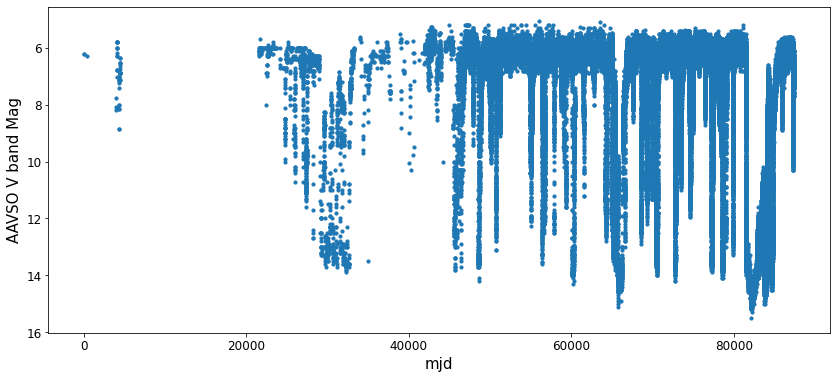

In [124]:
plt.figure(figsize=(14,6))

plt.scatter(vband['JD']-np.min(vband['JD']),vband['Magnitude'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd')
plt.ylabel('AAVSO V band Mag')
plt.show()

In [11]:
# # pretend this dataframe is something else
# oband = vband
# oband.rename(columns={"JD": "mjd", "Magnitude": "m"},inplace=True)
# oband

In [12]:
# oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
# oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
#     # this keeps the first entry, I'd love if it took an average
# oband

In [13]:
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o
4612,60085.289962,15.891,0.012,1597.0,20.0,o,0,7.68,295.57660,-20.54654,3483.49,4412.50,2.05,1.87,84.7,-0.423,19.29,20.65,04a60085o0743o
4613,60093.044580,18.811,0.103,108.0,11.0,c,0,1.20,295.57660,-20.54654,9278.83,6021.04,2.94,2.75,-33.6,-0.361,19.45,21.42,03a60093o0736c
4614,60093.047335,18.616,0.090,130.0,12.0,c,0,1.13,295.57660,-20.54654,9261.36,5982.77,2.91,2.67,-25.9,-0.358,19.48,21.42,03a60093o0742c


In [14]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,60079.361159,14.678,0.007,4884.0,33.0,o,0,32.80,295.57660,-20.54654,7076.95,2279.83,2.18,1.95,-19.6,-0.419,19.20,20.49,04a60079o0524o
4605,60079.384530,15.696,0.079,1912.0,150.0,o,0,0.98,295.57660,-20.54654,3581.78,8256.05,2.52,1.91,-79.3,-0.404,16.73,18.41,04a60079o0571o
4610,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [15]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.393173,12.691,0.003,30460.0,76.0,o,0,65.80,295.57660,-20.54654,10453.99,1565.49,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
2,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
3,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
4,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
3302,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
3303,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
3304,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [16]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1789,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1790,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1791,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


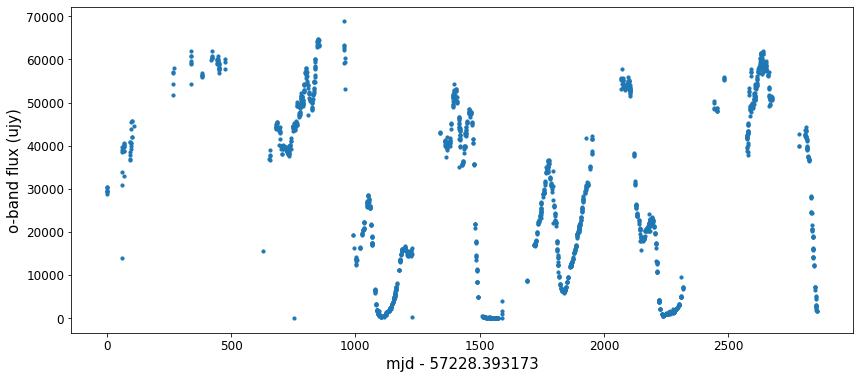

In [17]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(-100,1000)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [18]:
########################

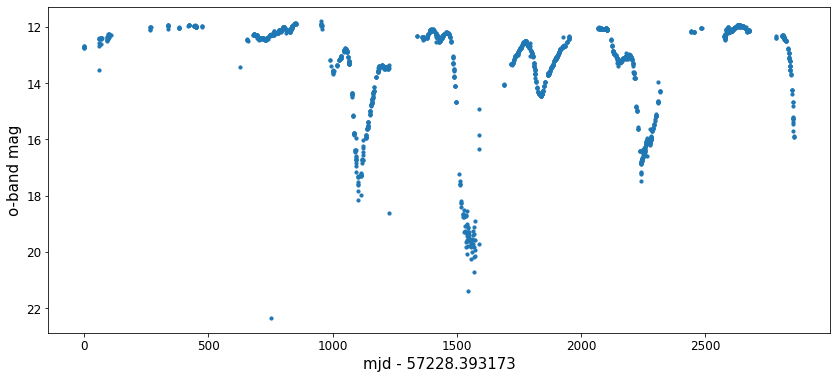

In [19]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band mag')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [20]:
# median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

In [21]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('median filtered o-band magnitude')
# plt.show()

In [22]:
### will fail if duplicate data points
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

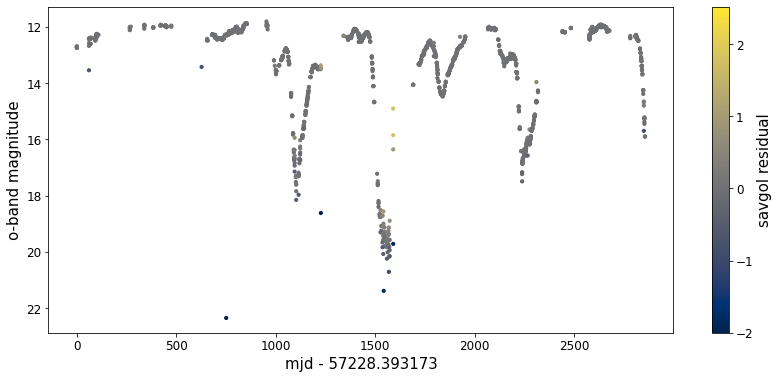

In [23]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.2830460655040933


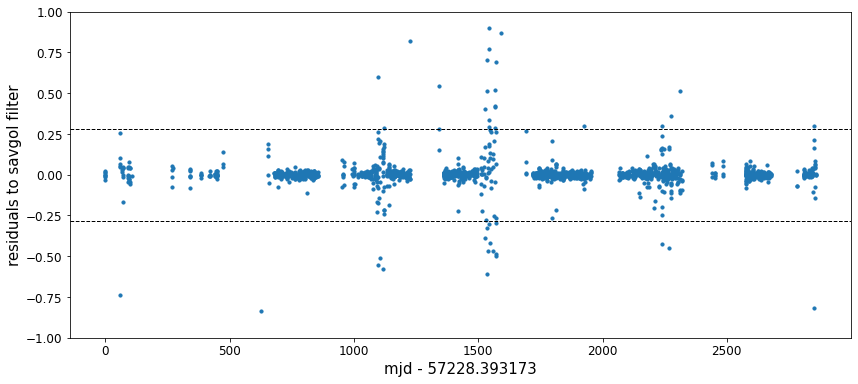

In [24]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [25]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
#             c=median_filtered-oband['m'],cmap='cividis')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band magnitude')
# plt.colorbar(label='median residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [26]:
# deviation = np.std((median_filtered-oband['m']))
# print(deviation)

# plt.figure(figsize=(14,6))
# # plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to median filter')
# plt.ylim(-1,1)
# plt.show()

In [27]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<deviation,True,False)
# mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

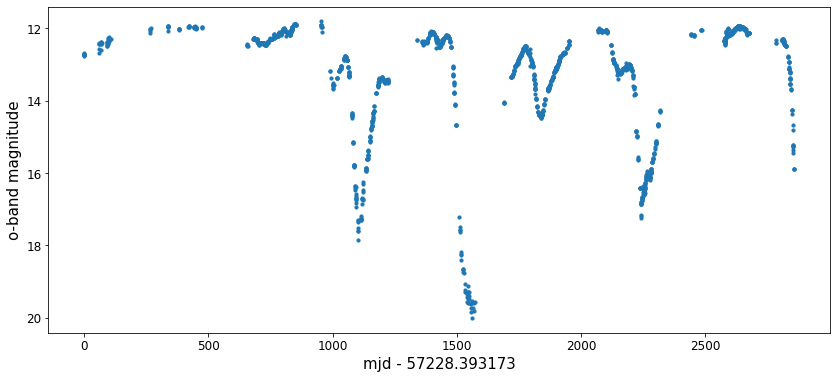

In [28]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [29]:
# median_filtered_oband = oband.iloc[mask]
# median_filtered_oband.reset_index(drop=True,inplace=True)
# median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

# savgol_filtered_oband = oband
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# savgol_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1735,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1736,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1737,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [30]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=31, polynom=1)

In [31]:
# iter_savgol_filtered = savgol_filtered_oband['m']

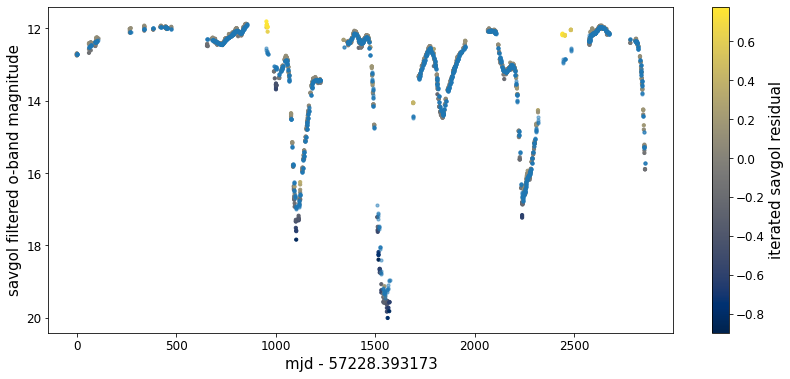

In [32]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.colorbar(label='iterated savgol residual')
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [33]:
# local_std/2

In [34]:
# I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
# and limiting mag is ~20
local_std = np.std((iter_savgol_filtered-savgol_filtered_oband['m']))
saturation_limit = 0#12
saturation_mask = []
halfwidth=5
for i in range(0,len(iter_savgol_filtered)):
    if i > len(iter_savgol_filtered)-halfwidth:
        saturation_mask.append(True)
    elif i < halfwidth:
        saturation_mask.append(True)
    else:
        variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_oband['m'][i-halfwidth:i+halfwidth]))
        if variation_window > 0.1 and np.mean(savgol_filtered_oband['m'][i-halfwidth:i+halfwidth])<saturation_limit:
    #         print('mask me')
            saturation_mask.append(False)
        else:
            saturation_mask.append(True)
# saturation_mask = np.where(np.abs(iter_savgol_filtered-savgol_filtered_oband['m'])<0.25,True,False)
# saturation_mask

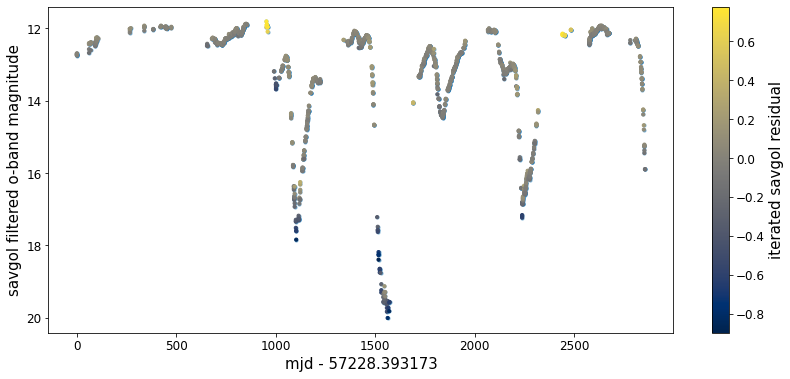

In [35]:
# saturation_replace = np.full(len(saturation_mask),11)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,alpha=0.5)
plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'][saturation_mask],s=10,
            c=iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][np.invert(saturation_mask)]-savgol_filtered_oband['mjd'][0],
#            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
plt.colorbar(label='iterated savgol residual')
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [36]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# # plt.ylim(-1,1)
# plt.show()

In [37]:
# mjd_scale = savgol_filtered_oband['mjd'][0]

# # median_filtered_oband['mjd']-mjd_scale,savgol_filtered
# time = savgol_filtered_oband['mjd']-mjd_scale

# # stddev_arr = []
# # saturation_mask = [False,False,False,False,False]
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# # print(deviation)

# ### find the gaps in the data
# time_diff = np.diff(time)
# time_diff = np.append(time_diff,0)

# gap_mask = []#[False,False]
# for i in range(0,len(time)):
#     if time_diff[i] > 50:
#         gap_mask.append(True)
# #     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
# #         gap_mask.append(True)
#     else:
#         gap_mask.append(False)
        
# noise_mask = np.full(len(time),False)
# for i in range(0,len(time[gap_mask])):
#     if i == 0:
#         window = time<=time[time[gap_mask].index[i]]
# #         print(window)
#     elif i == len(time[gap_mask])-1:
#         window = time>=time[time[gap_mask].index[i]]
# #         print(window)
#     else:
#         window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
# #     print(np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]))
# #     print(np.mean(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
# #     print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
#     if (np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation 
#         and len(savgol_filtered_oband['m'][window]) > 50 and 
#         (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window])) < 2.5
#        and (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m'])) < 3.0):
#         print(len(savgol_filtered_oband['m'][window]))
#         print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window]))
# #         print(i,'mask me')
#         noise_mask[window] = True
# #     print('------')
# noise_mask

In [38]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# # plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
# #             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# plt.ylim(-1,1)
# plt.show()

In [39]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
#             c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [40]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
# edge_detect = sp.ndimage.convolve(savgol_filtered_oband['m'], [1.0, 0.0, -1.0])

In [41]:
# mjd_scale = savgol_filtered_oband['mjd'][0]


# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detection')
# plt.ylim(-1,1)
# plt.show()

In [42]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,
#             c=edge_detect,cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-1,1)
# plt.show()

In [43]:
# ###### TAKE THIS OUT IF YOU DON'T WANT TO MASK THE SATURATION #######
# savgol_filtered_oband = savgol_filtered_oband.iloc[saturation_mask]
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# iter_savgol_filtered = savgol_filtered_oband['m']
# savgol_filtered_oband

In [44]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered),
#                                                  kind='cubic')
interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(iter_savgol_filtered),
                                                 kind='linear')
# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(savgol_filtered_oband['m']),
#                                                  kind='linear')

### attempting monotone interpolants ###
# interpolation_function = Akima1DInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is bad
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is better
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(savgol_filtered_oband['m'])) # this one is better


## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(savgol_filtered_oband['mjd']))
len_data = np.max(savgol_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

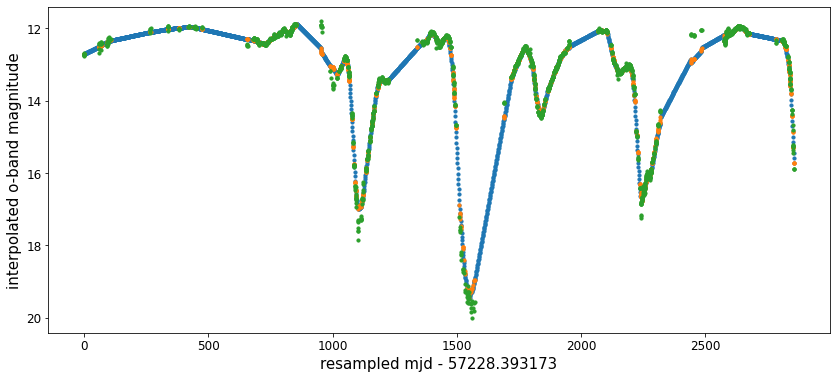

In [45]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(savgol_filtered_oband['m']),s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
# plt.ylim(20.5,11)
# plt.ylim(14,11)
# plt.xlim(1000,1200)
plt.show()

In [46]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

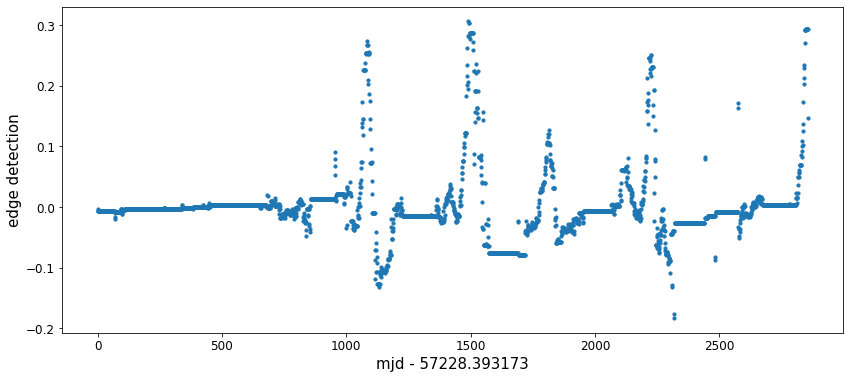

In [47]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

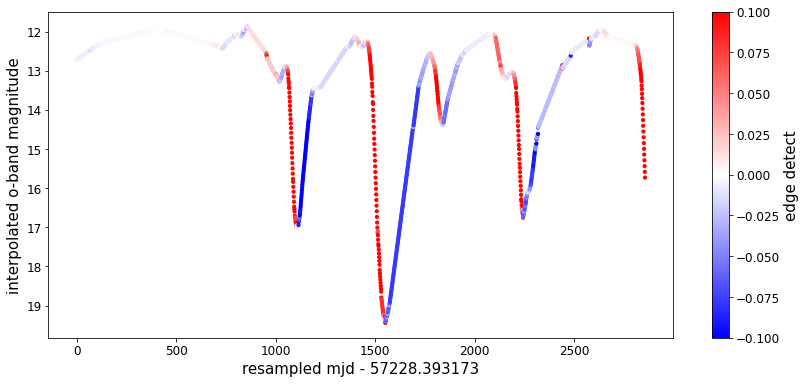

In [48]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [49]:
# kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = Matern(length_scale=3, nu=3/2,length_scale_bounds=(150,1e5)) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [50]:
# # median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

# time = np.asarray(savgol_filtered_oband['mjd']-mjd_scale)
# time = time.reshape(-1,1)

# # the gp assumes the mean value is zero
# mean_val = np.min(savgol_filtered_oband['m'])
# norm_val = np.max(savgol_filtered_oband['m']-mean_val)


# # mean_val = np.min(iter_savgol_filtered)
# # norm_val = np.max(iter_savgol_filtered-mean_val)

In [51]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(time, (savgol_filtered_oband['m']-mean_val)/norm_val)
# # gp.fit(time, (iter_savgol_filtered-mean_val)/norm_val)


# # gp.fit(time, savgol_filtered_oband['m'])
# # GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
# #                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
# #                 n_restarts_optimizer=0, normalize_y=False,
# #                 optimizer='fmin_l_bfgs_b', random_state=None)

In [52]:
# gp.kernel_

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [53]:
# x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
# y_pred, sigma = gp.predict(x_pred, return_std=True)

In [54]:
# plt.figure(figsize=(14,6))

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)
# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,alpha=0.5,color='tab:orange')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,iter_savgol_filtered,s=10,color='tab:blue',alpha=0.75)

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [55]:
# gpsmoothed_time = time
# gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)
# gpsmoothed_flux = (gpsmoothed_flux*norm_val)+mean_val
# gpsigma = gpsigma*norm_val

In [56]:
# plt.figure(figsize=(14,6))

# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [57]:
# gp_edge_detect = sp.ndimage.convolve((y_pred*norm_val)+mean_val, [1.0, 0.0, -1.0])

In [58]:
# # np.std()

# plt.figure(figsize=(14,6))
# plt.scatter(x_pred,gp_edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('edge detection')
# plt.ylim(-0.1,0.1)
# plt.show()

In [59]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(x_pred,(y_pred*norm_val)+mean_val,s=10,
#             c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [60]:
# ### remove this if you don't want to use the gp-filtered data
# resample_time = x_pred
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

In [61]:
# ## interpolate the edge detection to convert back to the original times
# # np.linspace(0, int(np.max(time)), int(np.max(time)))
# gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
#                                                  gp_edge_detect,
#                                                  kind='slinear')

# gp_edges = gp_edgedetect_interp(savgol_filtered_oband['mjd']-mjd_scale)

In [62]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
#             c=gp_edges,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [63]:
# plt.figure(figsize=(14,6))

# plt.scatter(gpsmoothed_time,(savgol_filtered_oband['m']-gpsmoothed_flux)+np.min(savgol_filtered_oband['m']),
#             s=10)#,c=gp_edges,cmap='bwr')
# plt.scatter(gpsmoothed_time,savgol_filtered_oband['m'],s=10,
#             c=savgol_filtered_oband['m']-gpsmoothed_flux,cmap='cividis')#,alpha=0.2)

# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='diff to gp model')
# plt.clim(-0.25,0.25)
# plt.show()

# Now back to normal

In [64]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [65]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [66]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [67]:
# ### toggle this cell for switching between slinear interpolation and GP interpolation ######

# resample_time = x_pred
# resample_time = resample_time.reshape(len(resample_time))
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

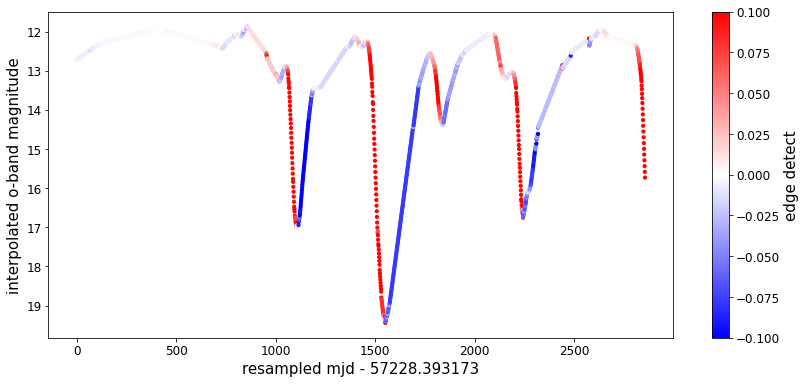

In [68]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

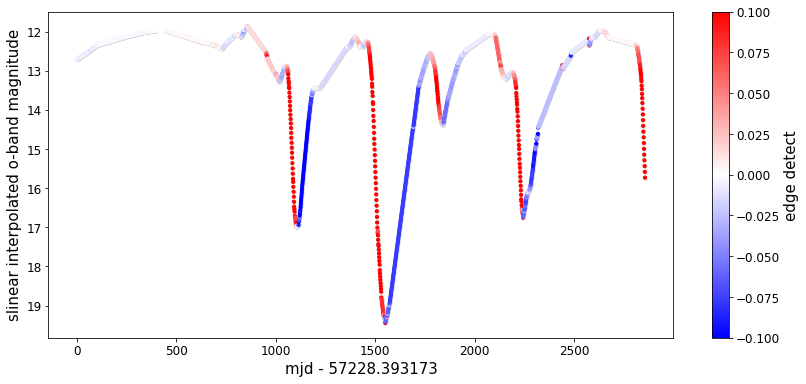

In [69]:
# std_dev = np.std(new_edge_detect)
# # std_dev
# new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
            c=new_edge_detect[new_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
#             c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

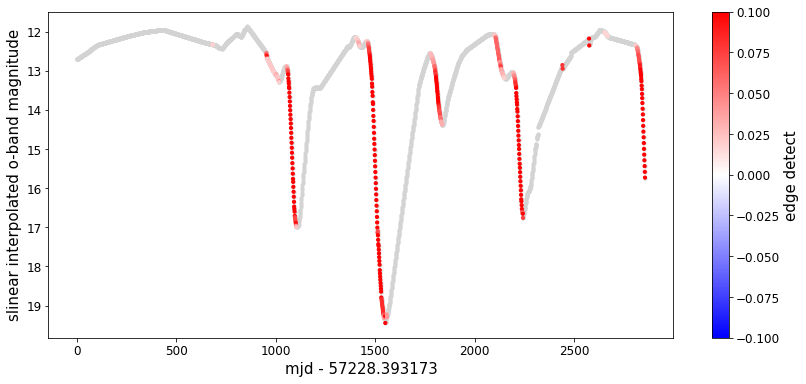

In [70]:
std_dev = np.std(new_edge_detect)
new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
downslope_mask = np.where(new_edge_detect>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=new_edge_detect[total_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [71]:
## this doesn't work with gp filtered data
gradient = np.gradient(resample_flux, resample_time)

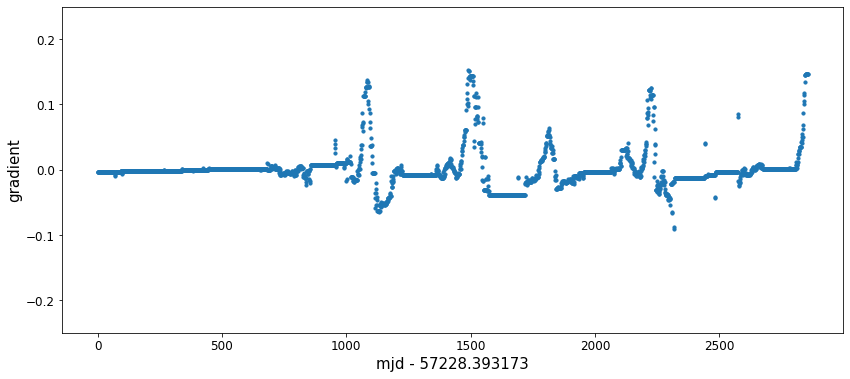

In [72]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
plt.ylim(-0.25,0.25)
plt.show()

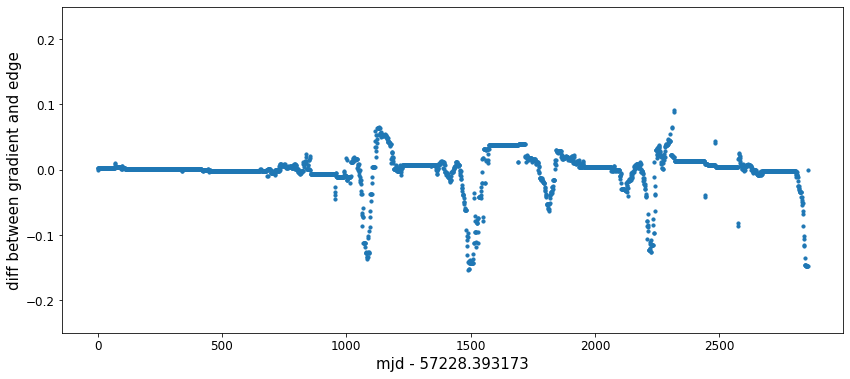

In [73]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient-new_edge_detect,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('diff between gradient and edge')
plt.ylim(-0.25,0.25)
plt.show()

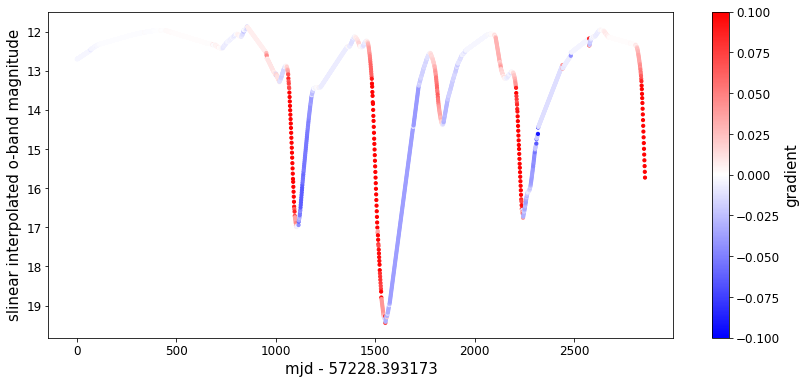

In [74]:
plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(resample_time,gradient,s=10,color='lightgrey')
plt.scatter(resample_time,resample_flux,s=10,
            c=gradient,cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

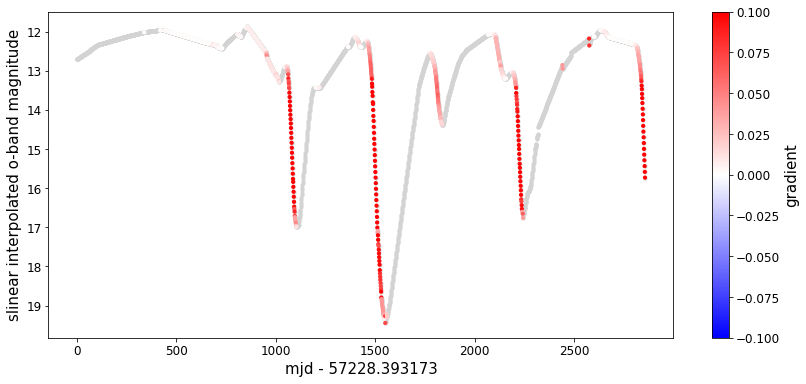

In [75]:
downslope_mask = np.where(gradient>0,True,False)
total_mask = downslope_mask

plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
            c=gradient[downslope_mask],cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [76]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [77]:
run_vals, run_start, run_length = find_runs(total_mask)

In [78]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [79]:
# resample_time[downward_mask]

In [80]:
# resample_time[run_start]

In [81]:
# resample_flux[run_start]

In [82]:
decline_min_depth = 0.9
decline_onset = []
decline_end = []
decline_depth = []
for i in range(0,len(resample_flux[run_start])):
    if i == 0 and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(resample_flux[0])
        print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
        decline_end.append(run_start[i+1])
        decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
    elif i == len(resample_flux[run_start])-1:
        if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(resample_flux[run_start[i]])
            print(resample_flux[-1] - resample_flux[run_start[i]])
            decline_end.append(len(resample_flux)-1)
            decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
    elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(resample_flux[run_start[i]])
        print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
        decline_end.append(run_start[i+1])
        decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
#     if i == len(resample_flux[run_start]):
#         print('end')
print(resample_flux[decline_end])
print(decline_depth)

856
11.875489258492097
1.244584789573878
1050
12.867493518584418
4.121525282641297
1455
12.228962821851585
7.094909189233711
1776
12.542040199944427
1.8511485398480012
2081
12.054590029857513
1.151291660030946
2185
13.02365766366836
3.5305641476989997
end
2643
11.974868128858345
3.75493958925429
[13.12007405 16.9890188  19.32387201 14.39318874 13.20588169 16.55422181
 15.72980772]
[1.244584789573878, 4.121525282641297, 7.094909189233711, 1.8511485398480012, 1.151291660030946, 3.5305641476989997, 3.75493958925429]


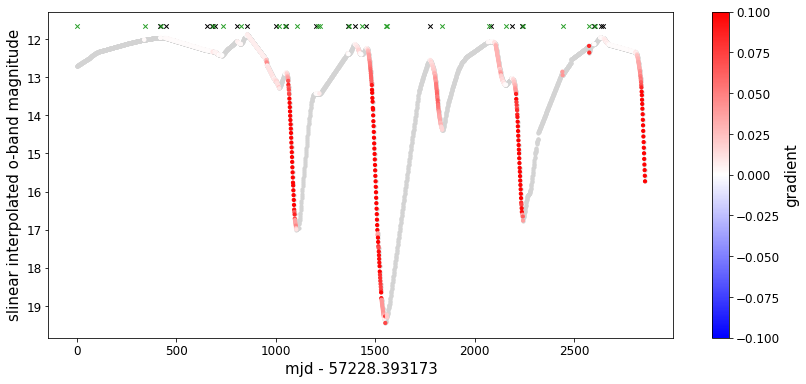

In [83]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downward_mask],
            np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
            s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[upward_mask],
            np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
plt.show()

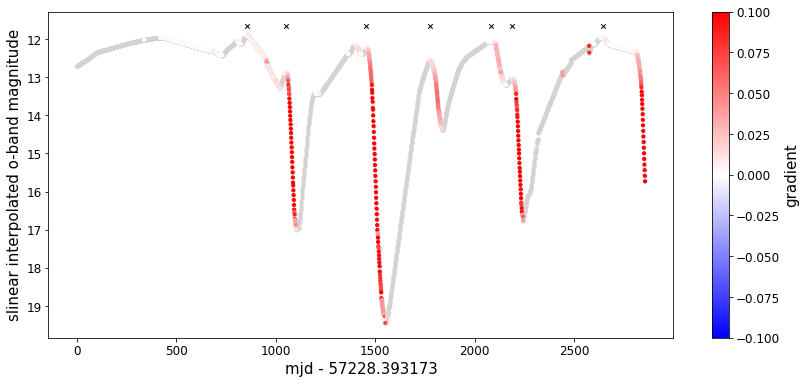

In [84]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
# plt.scatter(resample_time[downward_mask]-mjd_scale,
#             np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[upward_mask]-mjd_scale,
#             np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(resample_time[decline_onset],
            np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

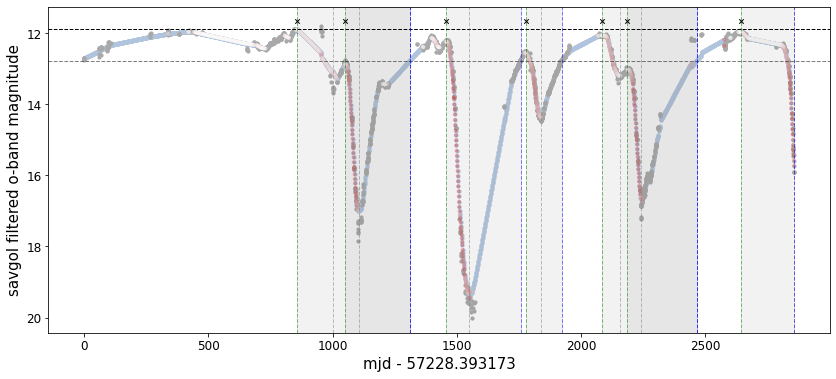

In [118]:
plt.figure(figsize=(14,6))

plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
plt.clim(-0.1,0.1)


onset_arr = []
onset_flag = []
max_depth_arr = []
end_arr = []
end_flag = []

max_light = np.min(resample_flux)
plt.axhline(max_light,color='k',linestyle='--')
plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
for i in range(0,len(resample_time[decline_onset])):
    flag_set = False
    if decline_onset[i] == 0:
#         print('beginning of array')
        onset_flag.append(1)
        flag_set = True
    onset_time = resample_time[decline_onset][i]
    diff_arr = np.abs((savgol_filtered_oband['mjd'][saturation_mask]-mjd_scale)-onset_time)
    if np.min(diff_arr) > 5:
        if decline_depth[i] > decline_min_depth:#12-np.min(savgol_filtered_oband['m']):
            plt.axvline(onset_time,color='red',linestyle='--')
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            if flag_set == False:
                onset_flag.append(2)
#             print('onset', onset_time)
        else:
#             print('bad onset')
            onset_flag.append(3)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            pass
#             plt.axvline(onset_time,color='red',linestyle='--')
    else:
        plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
        plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
        if flag_set == False:
            onset_flag.append(0)
        onset_arr.append(onset_time)
        max_depth_arr.append(resample_time[decline_end[i]])
#         print('onset', onset_time)
        
    post_decline_time = resample_time[resample_time>onset_time]
    post_decline_flux = resample_flux[resample_time>onset_time]
    xx = 0
    while post_decline_flux[xx] < (max_light+decline_min_depth):
        xx=xx+1
    else:
#         print('exited max light')
        exit_time = post_decline_time[xx]
        post_decline_time = resample_time[resample_time>exit_time]
        post_decline_flux = resample_flux[resample_time>exit_time]
    
    xx = 0
    try:
        while post_decline_flux[xx] > (max_light+decline_min_depth):
            xx=xx+1
        else:
#             print('reached max light')
#             print(xx,post_decline_flux[xx],post_decline_time[xx])
            plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx])
            end_flag.append(0)
    except IndexError:
#         print('reached end of array')
#         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
        plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
        end_arr.append(post_decline_time[xx-1])
        end_flag.append(1)

        
# print(onset_arr)
# print(onset_flag)
# print(end_arr)
# print(end_flag)
# print(max_depth_arr)

plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
            np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

for i in range(0,len(onset_arr)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
# plt.xlim(60000,80000)
plt.show()

In [86]:
def return_arr_to_orig(time_array):
    return_arr = []
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-datapt))
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

In [87]:
## resample the times back to the original data set
orig_time = savgol_filtered_oband['mjd']-mjd_scale
onset_arr_orig = return_arr_to_orig(onset_arr)
end_arr_orig = return_arr_to_orig(end_arr)
depth_time_orig = return_arr_to_orig(max_depth_arr)

In [88]:
def err_calculation(time_arr):
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     print(len(orig_time))
    err_arr = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
#         print(matched_time_ind)
        if matched_time_ind != 0 and matched_time_ind > 5 and matched_time_ind < (len(orig_time)-6):
            print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
            err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        elif matched_time_ind > (len(orig_time)-6):
            print('end of arr')
            err_arr.append(0)
        else:
            print('beginning of arr')
            err_arr.append(0)
    err_arr = np.asarray(err_arr)
    return err_arr

In [89]:
onset_err_arr = err_calculation(onset_arr_orig)
end_err_arr = err_calculation(end_arr_orig)
depth_err_arr = err_calculation(depth_time_orig)

52.22535599999901
4.981136999998853
5.529408499998681
5.502222999999503
7.981397999999899
0.9535854999994626
4.502269500000693
69.69685450000179
69.69685450000179
5.467148499999894
6.007459000000381
66.89449650000097
66.89449650000097
end of arr
20.988548000001174
6.959856000001309
7.97345249999853
6.0235370000009425
4.966773500000272
1.972089999999298
end of arr


In [90]:
## time error calculations based on how many data points are around
err_arr = []
for onset in onset_arr_orig:
    matched_time_ind = np.argmin(np.abs(orig_time-onset))
    if matched_time_ind != 0 and matched_time_ind > 5:
        print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
    else:
        print('beginning of arr')
        err_arr.append(0)
err_arr = np.asarray(err_arr)
#     print(orig_time[matched_time_ind-5:matched_time_ind+5])

52.22535599999901
4.981136999998853
5.529408499998681
5.502222999999503
7.981397999999899
0.9535854999994626
4.502269500000693


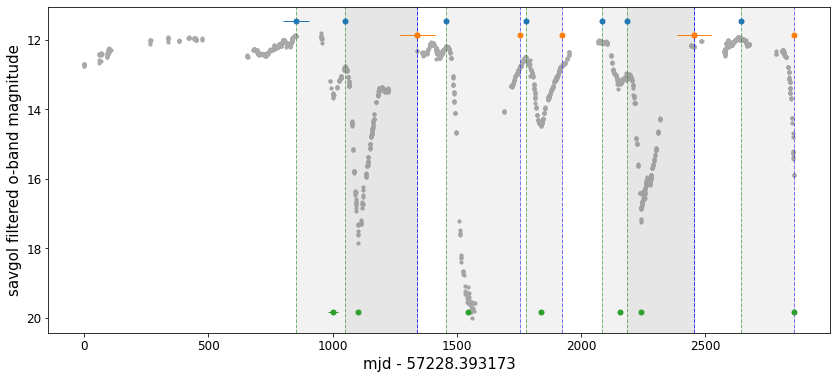

In [91]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
             xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')


# plt.scatter(end_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
             xerr=end_err_arr[np.asarray(onset_flag) != 3],fmt='o')

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=depth_time_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
             xerr=depth_err_arr[np.asarray(onset_flag) != 3],fmt='o')


for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
plt.show()

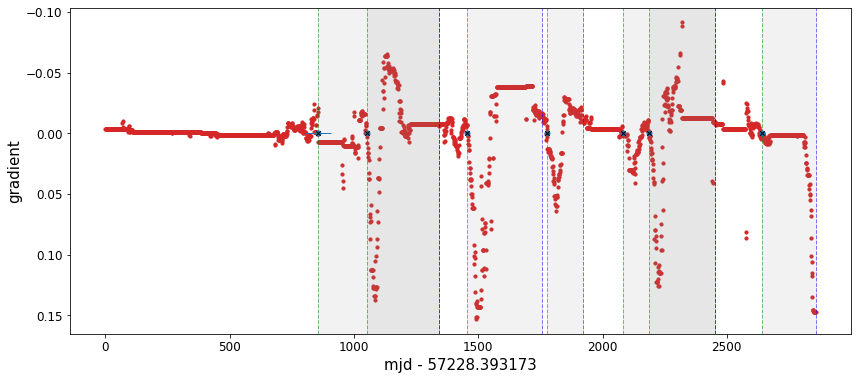

In [92]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(resample_time,gradient,s=10,color='tab:red')


# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
#             s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
            np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                    s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
             xerr=err_arr[np.asarray(onset_flag) != 3],fmt='o')

for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [93]:
## these times are in the resampled array, which has no gaps, compared to the real data
## We'll need to transform back to the original array and use the the distance to a datapoint as an error

decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
                        end_arr_orig,end_err_arr,end_flag,
                        depth_time_orig,depth_err_arr,
                        decline_depth,resample_flux[decline_end]])
decline_frame = pd.DataFrame(decline_arr.T,
                             columns=['onset_time','onset_err','onset_flag','end_time','end_err',
                                      'end_flag','depth_time','depth_err','decline_depth','min_mag'])
decline_frame

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,854.816873,52.225356,0.0,1341.239220,69.696855,0.0,1001.196791,20.988548,1.244585,13.120074
1,1051.104771,4.981137,0.0,1341.239220,69.696855,0.0,1103.022992,6.959856,4.121525,16.989019
2,1456.056373,5.529408,0.0,1755.193068,5.467148,0.0,1546.859514,7.973452,7.094909,19.323872
3,1777.074146,5.502223,0.0,1922.830736,6.007459,0.0,1839.079701,6.023537,1.851149,14.393189
4,2083.212729,7.981398,0.0,2454.242147,66.894497,0.0,2157.094810,4.966774,1.151292,13.205882
5,2186.019242,0.953585,0.0,2454.242147,66.894497,0.0,2238.969396,1.972090,3.530564,16.554222
6,2643.401151,4.502270,0.0,2856.896789,0.000000,1.0,2856.896789,0.000000,3.754940,15.729808


In [94]:
# decline_frame[decline_frame['onset_time']>45000]

In [95]:
# (87000-45000)/365

In [96]:
# plt.figure(figsize=(14,6))

# n = np.arange(-600,600)
# def rcrb_ephemeris(n):
#     return 2443192.4 + 42.97*n

# plt.scatter(rcrb_ephemeris(n)-mjd_scale,
#             np.full(len(n),np.min(resample_flux)),
#            marker='x',s=10,color='k')

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
#             s=10,color='darkgrey')

# plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
#             y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#              xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

# for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
#     plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
# for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
#     plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
# for i in range(0,len(onset_arr_orig)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
# plt.xlim(45000,88000)
# # plt.ylim(np.min(resample_flux)+1,np.min(resample_flux)-1)
# # plt.xlim(55000,60000)
# plt.show()

In [97]:
# from astropy.timeseries import LombScargle

In [98]:
# def calc_lomb_scargle(t,y):
#    oversample = 1
#    tmax = t.max()
#    tmin = t.min()
#    df = 1.0 / (tmax - tmin)
#    fmin = df
#    fmax = 1 # maximum frequency in cycles per day (c/d)
 
#    freq = np.arange(fmin, fmax, df / oversample)
#    model = LombScargle(t, y)
#    sc = model.power(freq, method="fast", normalization="psd")
 
#    fct = np.sqrt(4./len(t))
#    amp = np.sqrt(sc) * fct
#    return freq, amp*1E6 # return frequency in muHz and amplitude in ppm

In [99]:
# # freq, amp = calc_lomb_scargle(savgol_filtered_oband['mjd']-mjd_scale,
# #                               savgol_filtered_oband['m'])

# freq, amp = calc_lomb_scargle(savgol_filtered_oband['mjd'][savgol_filtered_oband['mjd']-mjd_scale>45000]-mjd_scale,
#                               savgol_filtered_oband['m'][savgol_filtered_oband['mjd']-mjd_scale>45000])

In [100]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# # plt.axvline(1/42,color='k',alpha=0.5)
# plt.axvline(3.4e-2,color='k')
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# # plt.xlim(30,50)
# # plt.xlim(0,0.1)
# # plt.xlim(0,100)
# # plt.yticks([])
# plt.yscale('log')
# plt.xscale('log')
# # plt.xlim(0.0,0.2)
# # plt.xlim(0.03,0.038)
# # plt.ylim(top=0.5e11)
# plt.show()

In [101]:
# 11.574/3.4e-2

In [102]:
# time = savgol_filtered_oband['mjd'][savgol_filtered_oband['mjd']-mjd_scale>45000]-mjd_scale
# is_decline = np.zeros(len(time))
# idx = np.isin(time, onset_arr_orig)
# is_decline[idx] = 2

In [103]:
# plt.figure(figsize=(10,2))
# plt.scatter(time,is_decline)
# plt.xlabel('decline onset (days)')
# # plt.yticks([])
# plt.show()

In [104]:
# freq, amp = calc_lomb_scargle(time,is_decline)

In [105]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# plt.axvline(1/42,color='k',alpha=0.5)
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# plt.show()

In [106]:
# plt.figure(figsize=(14,5))
# plt.plot(1/freq,amp**2)
# plt.axvline(42.97,color='k',alpha=0.5)
# # plt.axvline(18,color='k')
# plt.xlabel('period [days]')
# plt.ylabel('power')
# plt.xlim(0,200)
# plt.show()

In [107]:
# decline_mask = np.full(len(savgol_filtered_oband['mjd']),
#                        True)
# time = savgol_filtered_oband['mjd']-mjd_scale
# for i in range(0,len(onset_arr_orig)):
#     if onset_flag[i] != 3:
#         condition = np.logical_and(time > onset_arr_orig[i], time < end_arr_orig[i])
# #         print(~condition)
#         decline_mask = decline_mask & ~condition

In [108]:
# plt.figure(figsize=(14,6))

# plt.scatter(savgol_filtered_oband['mjd'][decline_mask]-mjd_scale,savgol_filtered_oband['m'][decline_mask],
#             s=10,color='darkgrey')

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
# plt.xlim(45000,88000)
# # plt.xlim(50000,55000)
# # plt.ylim(np.min(resample_flux)+1,np.min(resample_flux)-1)
# # plt.xlim(55000,60000)
# plt.show()

In [109]:
# maxlight_time = savgol_filtered_oband['mjd'][decline_mask]-mjd_scale
# maxlight_flux = savgol_filtered_oband['m'][decline_mask]

In [110]:
# freq, amp = calc_lomb_scargle(maxlight_time[maxlight_time>45000],
#                               maxlight_flux[maxlight_time>45000])

In [111]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# plt.axvline(1/42,color='k')
# # plt.axvline(3.4e-2,color='k')
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# plt.yscale('log')
# plt.xscale('log')
# plt.show()

In [112]:
# plt.figure(figsize=(14,5))
# plt.plot(freq,amp**2)
# # plt.axvline(1/42,color='k')
# plt.axvline(0.022,color='k')
# # plt.axvline(0.023,color='k')
# plt.axvline(3.4e-2,color='red')
# plt.xlabel('freq [uHz]')
# plt.ylabel('power')
# plt.yscale('log')
# plt.xscale('log')
# # plt.xlim(0.015,0.03)
# plt.xlim(10**-3,9e-1)
# # plt.ylim(-.1e8,0.5e8)
# plt.show()

In [113]:
# 1/0.022

In [114]:
# 0.0247-0.023

In [115]:
# def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
#     '''
#     Make an echelle plot used in asteroseismology.
    
#     Input parameters
#     ----
#     x: 1d array-like, freq
#     y: 1d array-like, power spectrum
#     period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
#     fmin: float, minimum frequency to be plotted
#     fmax: float, maximum frequency to be plotted
#     echelletype: str, `single` or `replicated`
#     offset: float, an amount by which the diagram is shifted horizontally
    
#     Return
#     ----
#     z: a 2d numpy.array, folded power spectrum
#     extent: a list, edges (left, right, bottom, top) 
    
#     Users can create an echelle diagram with the following command:
#     ----
    
#     import matplotlib.pyplot as plt
#     z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
#     plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
#     '''
    
#     if fmin is None: fmin=0.
#     if fmax is None: fmax=np.nanmax(x)

#     fmin = fmin - offset
#     fmax = fmax - offset
#     x = x - offset

#     fmin = 0.0 if fmin<0. else fmin - (fmin % period)

#     # define plotting elements
#     resolution = np.median(np.diff(x))
#     # number of vertical stacks
#     n_stack = int((fmax-fmin)/period) 
#     # number of point per stack
#     n_element = int(period/resolution) 

#     fstart = fmin - (fmin % period)
    
#     z = np.zeros([n_stack, n_element])
#     base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
#     for istack in range(n_stack):
#         z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
#     extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
#     return z, extent

In [116]:
# def echelle_wrapper(freq,power,dnu,fmin,fmax,smooth_percent=0.02):
#     fig,ax = plt.subplots(figsize=(8,8))
# #     fig,ax = plt.subplots(figsize=(6,8))
#     freq_res = np.median(np.diff(freq))
#     power = convolve(power, Box1DKernel((dnu*smooth_percent)/freq_res))
#     z, ext = yl_echelle(freq, power, dnu, fmin=fmin, fmax=fmax, echelletype="replicated")
#     z = np.sqrt(z) #sqrt scaling
#     ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
#     ax.axvline(dnu,color='k',linestyle='--',alpha=0.5)
#     ax.set_xlabel(r"Frequency mod "+str("{0:.5f}").format(dnu) + " ($\mu$Hz)",size=20)
# #     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)

In [117]:
# echelle_wrapper(freq,amp**2,0.00155,0.0125,0.03,smooth_percent=0.05)